<h1><font color='lightblue'>Sistemas de Recomendação</font></h1>
<h2><b>Sistema de recomendação colaborativa (<i>Collaborative Based Recommendation</i>)</b></h2>


---

# Recomendação Colaborativa


A ideia básica da recomendação colaborativa é considerar a avaliação de outros usuários similares (*user-user*) ou a avaliação de itens similares (*item-item*) para estimar a avaliação de itens não vistos para um usuário.


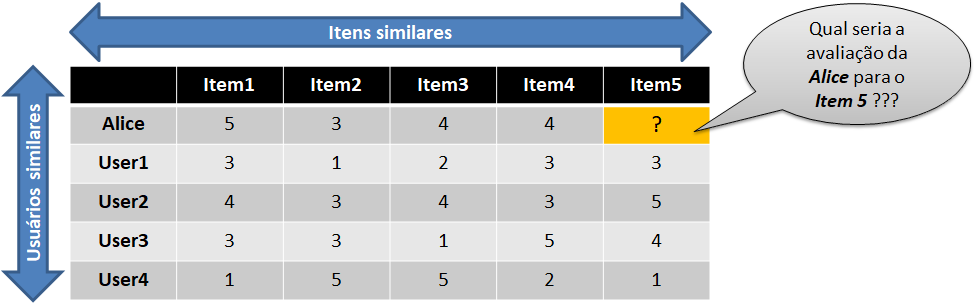

In [ ]:
!pip install -q scikit-surprise

## Exemplo: **Como funciona a recomendação colaborativa?**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [ ]:
vratings = [ (0,0,5), (0,1,3), (0,2,4), (0,3,4),
           (1,0,3), (1,1,1), (1,2,2), (1,3,3), (1,4,3),
           (2,0,4), (2,1,3), (2,2,4), (2,3,3), (2,4,5),
           (3,0,3), (3,1,3), (3,2,1), (3,3,5), (3,4,4), 
           (4,0,1), (4,1,5), (4,2,5), (4,3,2), (4,4,1) ]#  , (5,0,1), (5,1,5), (5,2,5)]

ratings = pd.DataFrame(vratings, columns=['user','item','rating']) 
m_ratings = ratings.pivot_table(values='rating', index='user', columns='item') 
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


### Avaliação média

Uma abordagem **não personalizada** para estimar a avaliação de um item para um usuário, **é usar a média das avaliações do item**. 

Uma desvantagem desta abordagem é que a mesma avaliação do item será atribuída a todos os usuários.

In [ ]:
avg_i = m_ratings.mean(axis=0)
avg_i

item
0    3.20
1    3.00
2    3.20
3    3.40
4    3.25
dtype: float64

In [ ]:
m1 = m_ratings.fillna(m_ratings.mean(axis=0))
m1

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,3.25
1,3.0,1.0,2.0,3.0,3.00
2,4.0,3.0,4.0,3.0,5.00
3,3.0,3.0,1.0,5.0,4.00
4,1.0,5.0,5.0,2.0,1.00


### *Memory-based:* ***User x User***

Abordagem que considera os usuários similares para estimar a avaliação de um item não visto.

#### Similaridade entre os usuários

A similaridade entre dois usuários pode ser medida utilizando-se diversas métricas que consideram o quanto as avaliações de cada um deles são semelhantes

**Similaridade do cosseno**

In [ ]:
sims = pd.DataFrame(cosine_similarity(m_ratings.fillna(0),m_ratings.fillna(0)))
sims

,0,1,2,3,4
0,1.000000,0.826869,0.810163,0.762770,0.789542
1,0.826869,1.000000,0.959383,0.935693,0.637815
2,0.810163,0.959383,1.000000,0.894427,0.771517
3,0.762770,0.935693,0.894427,1.000000,0.638311
4,0.789542,0.637815,0.771517,0.638311,1.000000


**Correlação de pearson**

In [ ]:
sims = m_ratings.T.corr(method='pearson')
sims

user,0,1,2,3,4
user,,,,,
0,1.000000,0.852803,0.707107,0.000000,-0.792118
1,0.852803,1.000000,0.467707,0.489956,-0.900149
2,0.707107,0.467707,1.000000,-0.161165,-0.466569
3,0.000000,0.489956,-0.161165,1.000000,-0.641503
4,-0.792118,-0.900149,-0.466569,-0.641503,1.000000


#### Estimando as avaliações

Avaliação média de cada usuário

In [ ]:
users = m_ratings.index
items = m_ratings.columns

m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


In [ ]:
avg_u = m_ratings.mean(axis=1)
avg_u

user
0    4.0
1    2.4
2    3.8
3    3.2
4    2.8
dtype: float64

In [ ]:
m_ratings.iloc[1].mean()

2.4

In [ ]:
soma = 0.0
aux = 0.0
for i, sim in enumerate(sims[0][1:]):
    if sim > 0:
        print(m_ratings.iloc[i+1][4],'-',m_ratings.iloc[i+1].mean(),'*',sim, '=', ( m_ratings.iloc[i+1][4] - m_ratings.iloc[i+1].mean()) * sim)
        aux += ( m_ratings.iloc[i+1][4] - m_ratings.iloc[i+1].mean()) * sim
        soma += sim
print(aux, '/',soma,'=', aux / soma)
print(avg_u[0],'+',aux / soma,'=',avg_u[0] + (aux/soma))


3.0 - 2.4 * 0.8528028654224417 = 0.5116817192534651
5.0 - 3.8 * 0.7071067811865475 = 0.8485281374238571
1.3602098566773222 / 1.5599096466089892 = 0.8719798993705921
4.0 + 0.8719798993705921 = 4.871979899370592


Função **`get_prediction_users()`**

In [ ]:
def get_prediction_users(users, items, sim='pearson', knn=10):
    preds = []

    m_ratings_T = m_ratings.T

    if sim == 'pearson':
        sims = m_ratings_T.corr(method='pearson')
    elif sim == 'cosine':
        sims = pd.DataFrame(cosine_similarity(m_ratings.fillna(0),m_ratings.fillna(0)))
    else:
        raise Exception('Similaridade deve ser "pearson" ou "cosine"')

    for user in users:
        # Seleciona os k vizinhos mais similares
        vizinhos = sims[user].drop(user).sort_values(ascending=False).index[:knn]
        for item in items:
            # Filtra as similaridades dos vizinhos que são positivas
            vsims = sims.loc[user][vizinhos]
            vsims = vsims[ vsims > 0]
            # Filtra os ratings não nulos dos vizinhos para o item
            vrats = m_ratings.loc[vsims.index][item] 
            hasRated = ~np.isnan(vrats)
            vrats = vrats[hasRated]
            # Filtra as similaridades correspondentes aos ratings não nulos
            vsims = vsims.loc[vrats.index]
            soma = vsims.sum()
            if soma > 0.0:
                pred_rating = (avg_u[user] + (np.dot(vsims, vrats - avg_u[vsims.index]) / soma))
            else:
                pred_rating = np.mean( np.array([ avg_i[item], avg_u[user] ]) )
            preds.append([ user, item, pred_rating ])
    
    preds_df = pd.DataFrame(preds, columns=['user','item','pred_rating'])
    pivot = preds_df.pivot_table(values='pred_rating', index='user', columns='item') 

    return preds, preds_df, pivot

#### Avaliando os resultados

In [ ]:
preds, preds_df, pivot = get_prediction_users([0], [4], sim='pearson')
pivot

item,4
user,
0,4.87198


In [ ]:
preds, preds_df, pivot = get_prediction_users(users, items, sim='pearson')
pivot

item,0,1,2,3,4
user,,,,,
0,4.418680,2.871980,3.871980,3.965380,4.871980
1,2.868583,1.668166,1.856294,2.680455,3.395354
2,4.640755,2.640755,3.640755,4.038867,4.400000
3,3.800000,1.800000,2.800000,3.800000,3.800000
4,3.000000,2.900000,3.000000,3.100000,3.025000


In [ ]:
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

compare = pd.merge(preds_df, ratings)
y_true = compare['rating'].values
y_pred = compare['pred_rating'].values

compare.head()


,user,item,pred_rating,rating
0,0,0,4.418680,5
1,0,1,2.871980,3
2,0,2,3.871980,4
3,0,3,3.965380,4
4,1,0,2.868583,3


In [ ]:
print('Raiz quadrada do erro quadrático médio (RMSE)')
rmse(y_true, y_pred)

Raiz quadrada do erro quadrático médio (RMSE)


1.0751597116920282

#### Comparando os resultados usando pearson e cosseno

In [ ]:
preds, preds_df, pivot = get_prediction_users(users, items, sim='cosine')
pivot

item,0,1,2,3,4
user,,,,,
0,3.712927,3.930610,3.965568,4.184785,4.206110
1,2.305809,2.287396,2.262057,2.520987,2.696794
2,3.747075,3.615209,3.609589,4.256525,3.762840
3,3.309591,2.771677,3.574131,2.994264,3.396793
4,3.222557,1.944448,2.269507,3.122304,3.688416


In [ ]:
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


In [ ]:
compare = pd.merge(preds_df, ratings)
y_true = compare['rating'].values
y_pred = compare['pred_rating'].values

print('Raiz quadrada do erro quadrático médio (RMSE)')
rmse(y_true, y_pred)

Raiz quadrada do erro quadrático médio (RMSE)


1.4458478978185871

#### A biblioteca ***Surprise***

Biblioteca para sistemas de recomendação em python


[Suprise](http://surpriselib.com/)



In [ ]:
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

##### Preparando os arquivos

In [ ]:
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


In [ ]:
ratings.head(10)

,user,item,rating
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,4
4,1,0,3
5,1,1,1
6,1,2,2
7,1,3,3
8,1,4,3
9,2,0,4


In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)

x = list(data.build_full_trainset().all_ratings())
x[:10]

[(0, 0, 5.0),
 (0, 1, 3.0),
 (0, 2, 4.0),
 (0, 3, 4.0),
 (1, 0, 3.0),
 (1, 1, 1.0),
 (1, 2, 2.0),
 (1, 3, 3.0),
 (1, 4, 3.0),
 (2, 0, 4.0)]

In [ ]:
trainset = data.build_full_trainset()
testset = trainset.build_testset()

##### Estimando usando cosseno

In [ ]:
algo = KNNWithMeans(k=10, sim_options={'name': 'cosine', 'user_based': True})

# Analisa os dados dos usuários similares
algo.fit(trainset)

# Realiza as predições
kMeans_test_predictions = algo.test(testset)

# Exibe os resultados
df = pd.DataFrame(kMeans_test_predictions)
df.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,0,0,5.0,4.036834,"{'actual_k': 5, 'was_impossible': False}"
1,0,1,3.0,3.659574,"{'actual_k': 5, 'was_impossible': False}"
2,0,2,4.0,3.914380,"{'actual_k': 5, 'was_impossible': False}"
3,0,3,4.0,4.162697,"{'actual_k': 5, 'was_impossible': False}"
4,1,0,3.0,2.495823,"{'actual_k': 5, 'was_impossible': False}"


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,4.036834,3.659574,3.914380,4.162697,NaN
1,2.495823,1.972608,2.208471,2.623257,2.782618
2,3.843369,3.449831,3.701646,3.966405,4.104094
3,3.264706,2.807274,2.972637,3.460423,3.570706
4,2.645491,2.739000,2.980758,2.829767,2.806286


In [ ]:
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


In [ ]:
# Calcula o RMSE
print(accuracy.rmse(kMeans_test_predictions))

RMSE: 1.0662
1.0662083294216442


##### Estimando valores ausentes

In [ ]:
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


In [ ]:
ausentes = trainset.build_anti_testset()
ausentes

[(0, 4, 3.2083333333333335)]

In [ ]:
algo.test(ausentes)

[Prediction(uid=0, iid=4, r_ui=3.2083333333333335, est=4.288490506121162, details={'actual_k': 4, 'was_impossible': False})]

##### Estimando usando pearson

In [ ]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)
kMeans_test_predictions = algo.test(testset)

df = pd.DataFrame(kMeans_test_predictions)
df.head()

Computing the pearson similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,0,0,5.0,4.645766,"{'actual_k': 3, 'was_impossible': False}"
1,0,1,3.0,2.921990,"{'actual_k': 3, 'was_impossible': False}"
2,0,2,4.0,3.921990,"{'actual_k': 3, 'was_impossible': False}"
3,0,3,4.0,3.978904,"{'actual_k': 3, 'was_impossible': False}"
4,1,0,3.0,2.915343,"{'actual_k': 4, 'was_impossible': False}"


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,4.645766,2.921990,3.921990,3.978904,NaN
1,2.915343,1.430424,1.907426,2.794153,3.193402
2,4.346130,2.805939,3.805939,3.561186,4.808801
3,3.263071,2.605393,1.591911,4.605393,3.934232
4,1.000000,5.000000,5.000000,2.000000,1.000000


In [ ]:
print(accuracy.rmse(kMeans_test_predictions))

RMSE: 0.2662
0.26620858008455345


In [ ]:
algo.test(ausentes)

[Prediction(uid=0, iid=4, r_ui=3.2083333333333335, est=4.871979899370592, details={'actual_k': 2, 'was_impossible': False})]

##### Usando uma variação de pearson otimizada para conjuntos pequenos

Ao invés de comparar cada valor com a média usa uma outra medida (baseline) para a comparação.

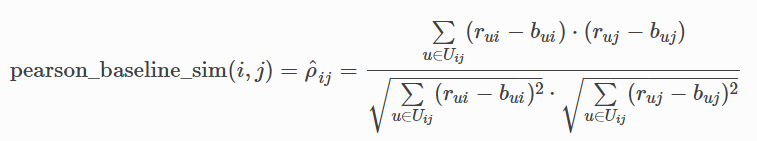

In [ ]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)
kMeans_test_predictions = algo.test(testset)

df = pd.DataFrame(kMeans_test_predictions).head()
df.head()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,0,0,5.0,4.984577,"{'actual_k': 2, 'was_impossible': False}"
1,0,1,3.0,3.003856,"{'actual_k': 2, 'was_impossible': False}"
2,0,2,4.0,4.003856,"{'actual_k': 2, 'was_impossible': False}"
3,0,3,4.0,3.984577,"{'actual_k': 2, 'was_impossible': False}"
4,1,0,3.0,2.988887,"{'actual_k': 2, 'was_impossible': False}"


In [ ]:
print(accuracy.rmse(kMeans_test_predictions))

RMSE: 0.0123
0.012307218859778183


In [ ]:
algo.test(ausentes)

[Prediction(uid=0, iid=4, r_ui=3.2083333333333335, est=5, details={'actual_k': 1, 'was_impossible': False})]

### *Memory-based*: ***Item x Item***

Abordagem que considera os itens similares para estimar a avaliação de um item não visto.

#### Similaridade entre os itens

Além da similaridade do cosseno e do coeficiente de pearson, será utilizada uma medida do cosseno ajustada pela avaliação média do usuário

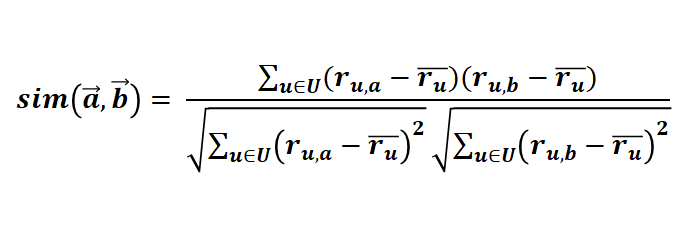

Avaliações

In [ ]:
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


Avaliações ajustadas

In [ ]:
m_ratings_T = m_ratings.T
adj_m_ratings = m_ratings_T - avg_u
adj_m_ratings = adj_m_ratings.fillna(0)
adj_m_ratings


user,0,1,2,3,4
item,,,,,
0,1.0,0.6,0.2,-0.2,-1.8
1,-1.0,-1.4,-0.8,-0.2,2.2
2,0.0,-0.4,0.2,-2.2,2.2
3,0.0,0.6,-0.8,1.8,-0.8
4,0.0,0.6,1.2,0.8,-1.8


Cálculo da similaridade ajustada

In [ ]:
sims = pd.DataFrame(cosine_similarity(adj_m_ratings,adj_m_ratings))
sims

,0,1,2,3,4
0,1.000000,-0.939725,-0.547068,0.267841,0.713758
1,-0.939725,1.000000,0.620543,-0.360645,-0.853001
2,-0.547068,0.620543,1.000000,-0.881380,-0.763560
3,0.267841,-0.360645,-0.881380,1.000000,0.433063
4,0.713758,-0.853001,-0.763560,0.433063,1.000000


In [ ]:
soma = 0.0
aux = 0.0
for i, sim in enumerate(sims[4][0:4]):
    if sim > 0:
        print(m_ratings.T.iloc[i][0],'*',sim, '=', m_ratings.T.iloc[i][0] * sim)
        aux += ( m_ratings.T.iloc[i][0]) * sim
        soma += sim
print(aux, '/',soma,'=', aux / soma)


5.0 * 0.7137575649774492 = 3.568787824887246
4.0 * 0.4330626889286792 = 1.7322507557147169
5.301038580601963 / 1.1468202539061285 = 4.622379629716474


Função **`get_prediction_items()`**

In [ ]:
def get_prediction_items(users, items, sim='pearson', knn=10):
    preds = []

    m_ratings_T = m_ratings.T
    adj_m_ratings = m_ratings_T - avg_u
    adj_m_ratings = adj_m_ratings.fillna(0)

    if sim == 'pearson':
        sims = m_ratings_T.corr(method='pearson')
    elif sim == 'cosine':
        sims = pd.DataFrame(cosine_similarity(m_ratings.fillna(0),m_ratings.fillna(0)))
    elif sim == 'adj_cosine':
        sims = pd.DataFrame(cosine_similarity(adj_m_ratings, adj_m_ratings))
    else:
        raise Exception('Similaridade deve ser "pearson" ou "cosine"')

    for item in items:
        # Seleciona os k vizinhos mais similares
        vizinhos = sims[item].drop(item).sort_values(ascending=False).index[:knn]
        for user in users:
            # Filtra as similaridades dos itens vizinhos que são positivas
            vsims = sims.loc[item][vizinhos]
            vsims = vsims[ vsims > 0]
            # Filtra os ratings não nulos dos vizinhos para o usuário
            vrats = m_ratings_T.loc[vsims.index][user]
            hasRated = ~np.isnan(vrats)
            vrats = vrats[hasRated]
            # Filtra as similaridades correspondentes aos ratings não nulos
            vsims = vsims.loc[vrats.index]
            soma = vsims.sum()
            if soma > 0.0:
                pred_rating = (np.dot(vsims, vrats) / soma)
            else:
                pred_rating = np.mean( np.array([ avg_i[item], avg_u[user] ]) )

            preds.append([ user, item, pred_rating ])
    
    preds_df = pd.DataFrame(preds, columns=['user','item','pred_rating'])
    pivot = preds_df.pivot_table(values='pred_rating', index='user', columns='item') 

    return preds, preds_df, pivot

In [ ]:
preds, preds_df, pivot = get_prediction_items([0],[4],sim='adj_cosine')
pivot

item,4
user,
0,4.62238


#### Estimando usando pearson

In [ ]:
preds, preds_df, pivot = get_prediction_items(users, items,sim='pearson')
pivot

item,0,1,2,3,4
user,,,,,
0,3.4533,4.471041,4.203777,3.0,3.625
1,1.4533,2.741665,2.203777,1.0,2.825
2,3.4533,3.729376,3.601888,3.0,3.525
3,2.0934,3.024578,3.000000,3.0,3.225
4,5.0000,2.303965,2.592447,5.0,3.025


In [ ]:
m_ratings

item,0,1,2,3,4
user,,,,,
0,5.0,3.0,4.0,4.0,NaN
1,3.0,1.0,2.0,3.0,3.0
2,4.0,3.0,4.0,3.0,5.0
3,3.0,3.0,1.0,5.0,4.0
4,1.0,5.0,5.0,2.0,1.0


In [ ]:
compare = pd.merge(preds_df, ratings)
y_true = compare['rating'].values
y_pred = compare['pred_rating'].values

print('Raiz quadrada do erro quadrático médio (RMSE)')
rmse(y_true, y_pred)

Raiz quadrada do erro quadrático médio (RMSE)


1.7059854829137673

#### Estimando usando cosseno

In [ ]:
preds, preds_df, pivot = get_prediction_items(users, items, sim='cosine')
pivot

item,0,1,2,3,4
user,,,,,
0,3.655443,4.303779,3.943986,3.933309,4.053478
1,2.227458,2.714449,2.441487,2.144029,2.278458
2,3.749134,3.911340,3.684967,3.907965,3.550214
3,3.217837,3.175737,3.745271,2.643927,2.906100
4,3.292289,2.420705,2.377376,3.265560,3.211924


In [ ]:
compare = pd.merge(preds_df, ratings)
y_true = compare['rating'].values
y_pred = compare['pred_rating'].values

print('Raiz quadrada do erro quadrático médio (RMSE)')
rmse(y_true, y_pred)

Raiz quadrada do erro quadrático médio (RMSE)


1.4728224248130546

#### Estimando usando cosseno ajustado pela avaliação média do usuário

In [ ]:
preds, preds_df, pivot = get_prediction_items(users, items, sim='adj_cosine')
pivot

item,0,1,2,3,4
user,,,,,
0,4.000000,4.0,3.0,5.000000,4.622380
1,3.000000,2.0,1.0,3.000000,3.000000
2,4.454276,4.0,3.0,4.617863,3.622380
3,4.272862,1.0,3.0,3.617863,3.755241
4,1.272862,5.0,5.0,1.000000,1.377620


In [ ]:
compare = pd.merge(preds_df, ratings)
y_true = compare['rating'].values
y_pred = compare['pred_rating'].values

rmse(y_true, y_pred)

1.0313648677937892

#### Estimando usando ***Surprise***

Usando cosseno

In [ ]:
algo = KNNWithMeans(k=10, sim_options={'name': 'cosine', 'user_based': False}) # Item-Item
algo.fit(trainset)
kMeans_test_predictions = algo.test(testset)

df = pd.DataFrame(kMeans_test_predictions)
df.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,0,0,5.0,4.052807,"{'actual_k': 4, 'was_impossible': False}"
1,0,1,3.0,3.746968,"{'actual_k': 4, 'was_impossible': False}"
2,0,2,4.0,3.974438,"{'actual_k': 4, 'was_impossible': False}"
3,0,3,4.0,4.218175,"{'actual_k': 4, 'was_impossible': False}"
4,1,0,3.0,2.457273,"{'actual_k': 5, 'was_impossible': False}"


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,4.052807,3.746968,3.974438,4.218175,NaN
1,2.457273,2.115739,2.323272,2.633575,2.528864
2,3.821079,3.541090,3.763856,3.981657,3.875135
3,3.255415,2.926300,3.067034,3.486632,3.355738
4,2.600262,2.797980,3.002506,2.850224,2.573340


In [ ]:
print(accuracy.rmse(kMeans_test_predictions))

RMSE: 1.0755
1.0754790333721105


In [ ]:
algo.test(ausentes)

[Prediction(uid=0, iid=4, r_ui=3.2083333333333335, est=4.113358032060099, details={'actual_k': 4, 'was_impossible': False})]

Usando pearson

In [ ]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)
kMeans_test_predictions = algo.test(testset)

df = pd.DataFrame(kMeans_test_predictions)
df.head()

Computing the pearson similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,0,0,5.0,4.583197,"{'actual_k': 2, 'was_impossible': False}"
1,0,1,3.0,3.313825,"{'actual_k': 2, 'was_impossible': False}"
2,0,2,4.0,3.686175,"{'actual_k': 2, 'was_impossible': False}"
3,0,3,4.0,4.416803,"{'actual_k': 2, 'was_impossible': False}"
4,1,0,3.0,2.938077,"{'actual_k': 3, 'was_impossible': False}"


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,4.583197,3.313825,3.686175,4.416803,NaN
1,2.938077,1.313825,1.686175,3.091628,2.984800
2,4.112873,3.313825,3.686175,3.893731,4.148776
3,3.751072,2.136982,1.863018,4.312938,3.832795
4,1.150810,4.921544,5.000000,1.564697,1.212806


In [ ]:
print(accuracy.rmse(kMeans_test_predictions))

RMSE: 0.4701
0.47011966351978585


In [ ]:
algo.test(ausentes)

[Prediction(uid=0, iid=4, r_ui=3.2083333333333335, est=4.6, details={'actual_k': 2, 'was_impossible': False})]

Usando pearson ajustado

In [ ]:
algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)
kMeans_test_predictions = algo.test(testset)

df = pd.DataFrame(kMeans_test_predictions)
df.head()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,0,0,5.0,4.979380,"{'actual_k': 2, 'was_impossible': False}"
1,0,1,3.0,3.018768,"{'actual_k': 2, 'was_impossible': False}"
2,0,2,4.0,3.981232,"{'actual_k': 2, 'was_impossible': False}"
3,0,3,4.0,4.020620,"{'actual_k': 2, 'was_impossible': False}"
4,1,0,3.0,2.995428,"{'actual_k': 3, 'was_impossible': False}"


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,4.979380,3.018768,3.981232,4.020620,NaN
1,2.995428,1.018768,1.981232,3.005627,2.998996
2,4.003039,3.018768,3.981232,3.052445,4.944910
3,3.053333,2.948389,1.051611,4.956828,3.989404
4,1.012193,4.995308,5.000000,1.973755,1.013828


In [ ]:
print(accuracy.rmse(kMeans_test_predictions))

RMSE: 0.0289
0.02887519566478596


In [ ]:
algo.test(ausentes)

[Prediction(uid=0, iid=4, r_ui=3.2083333333333335, est=4.596612742826166, details={'actual_k': 2, 'was_impossible': False})]

### *Model-based*: Fatoração de matrizes com ***SVD (Single Value Decomposition)***

Considerar um modelo pré-processado de decomposição em valores singulares (SVD) para tratar as matrizes esparsas de Usuários x Itens e reduzir a dimensionalidade para se diminuir o custo computacional e se aproximar o valor da estimativa de avaliações.

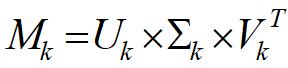

onde $U$ e $V$ são matrizes de rotação e $\sum$ é chamada de matriz de escala.

O valor de $k$ irá determinar o número de dimensões a considerar. 

Quanto maior o valor de $k$ maior a precisão, mas maior também o custo computacional.

#### Decomposição de matrizes em valores singulares

In [ ]:
from scipy.linalg import svd

A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print('Matriz')
print(A,'\n')

# Singular-value decomposition
U, s, VT = svd(A)
print('Matriz U')
print(U,'\n')
print('Matriz de escala')
print(np.diag(s),'\n')
print('Matriz V.T')
print(VT,'\n')

# Reconstruindo a matriz
Sigma = np.zeros((A.shape[0], A.shape[1]))
Sigma[:A.shape[1], :A.shape[1]] = np.diag(s)
B = U.dot(Sigma.dot(VT))

print('Matriz reconstruída pelo SVD')
print(B)

Matriz
[[1 2 3]
 [4 5 6]
 [7 8 9]] 

Matriz U
[[-0.21483724  0.88723069  0.40824829]
 [-0.52058739  0.24964395 -0.81649658]
 [-0.82633754 -0.38794278  0.40824829]] 

Matriz de escala
[[1.68481034e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.06836951e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.41842475e-16]] 

Matriz V.T
[[-0.47967118 -0.57236779 -0.66506441]
 [-0.77669099 -0.07568647  0.62531805]
 [-0.40824829  0.81649658 -0.40824829]] 

Matriz reconstruída pelo SVD
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


#### Estimando avaliações com SVD

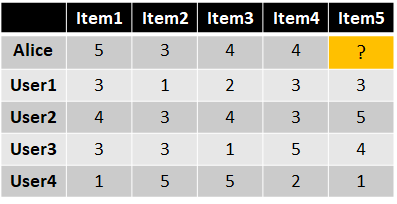

In [ ]:
A = m_ratings.values
A[0][4] = 4
A

array([[5., 3., 4., 4., 4.],
       [3., 1., 2., 3., 3.],
       [4., 3., 4., 3., 5.],
       [3., 3., 1., 5., 4.],
       [1., 5., 5., 2., 1.]])

##### Criando as matrizes de transformação

In [ ]:
# Singular-value decomposition
U, s, VT = svd(A)
print('Matriz U')
print(U,'\n')
print('Matriz de escala')
print(np.diag(s),'\n')
print('Matriz V.T')
print(VT,'\n')


Matriz U
[[-0.54417771 -0.08754568  0.30370119 -0.59826179 -0.4960391 ]
 [-0.33058186 -0.2706653   0.15579408 -0.28125406  0.84503271]
 [-0.51760066 -0.04376997  0.42947658  0.73701066 -0.05038748]
 [-0.43828512 -0.37356355 -0.80090286  0.12986388 -0.10023178]
 [-0.36685415  0.88182227 -0.23999639 -0.05412611  0.16516544]] 

Matriz de escala
[[16.49895292  0.          0.          0.          0.        ]
 [ 0.          4.93904963  0.          0.          0.        ]
 [ 0.          0.          2.58238958  0.          0.        ]
 [ 0.          0.          0.          1.20841267  0.        ]
 [ 0.          0.          0.          0.          0.51121848]] 

Matriz V.T
[[-0.45243758 -0.40396764 -0.43522962 -0.46344712 -0.47739116]
 [-0.33684063  0.53123751  0.6011186  -0.28298192 -0.40361214]
 [ 0.41089445 -0.48302671  0.48149762 -0.58623623  0.14945928]
 [-0.45643594  0.21015474 -0.12270585 -0.40111314  0.75601107]
 [-0.55196976 -0.52641907  0.44981655  0.44785414  0.12370973]] 



##### Reconstruindo a matriz original

In [ ]:
Sigma = np.zeros((A.shape[0], A.shape[1]))
Sigma = np.diag(s)
B = U.dot(Sigma.dot(VT))

print('Matriz original')
print(A,'\n')
print('Matriz reconstruída pelo SVD')
print(B)

Matriz original
[[5. 3. 4. 4. 4.]
 [3. 1. 2. 3. 3.]
 [4. 3. 4. 3. 5.]
 [3. 3. 1. 5. 4.]
 [1. 5. 5. 2. 1.]] 

Matriz reconstruída pelo SVD
[[5. 3. 4. 4. 4.]
 [3. 1. 2. 3. 3.]
 [4. 3. 4. 3. 5.]
 [3. 3. 1. 5. 4.]
 [1. 5. 5. 2. 1.]]


##### Usando $k$ fatores para reconstruir a matriz

In [ ]:
top = 2
Sigma = np.zeros((A.shape[0], A.shape[1]))
Sigma = np.diag(s)[:top,:top]
B = U[:,:top].dot(Sigma.dot(VT[:top]))
print(U[:,:top],'\n')
print(np.diag(s)[:top,:top],'\n')
print(VT[:top],'\n')

print('Matriz original')
print(A,'\n')
print('Matriz reconstruída pelo SVD')
print(B)

[[-0.54417771 -0.08754568]
 [-0.33058186 -0.2706653 ]
 [-0.51760066 -0.04376997]
 [-0.43828512 -0.37356355]
 [-0.36685415  0.88182227]] 

[[16.49895292  0.        ]
 [ 0.          4.93904963]] 

[[-0.45243758 -0.40396764 -0.43522962 -0.46344712 -0.47739116]
 [-0.33684063  0.53123751  0.6011186  -0.28298192 -0.40361214]] 

Matriz original
[[5. 3. 4. 4. 4.]
 [3. 1. 2. 3. 3.]
 [4. 3. 4. 3. 5.]
 [3. 3. 1. 5. 4.]
 [1. 5. 5. 2. 1.]] 

Matriz reconstruída pelo SVD
[[4.20779589 3.39726479 3.64773016 4.28335551 4.46070975]
 [2.91800812 1.49316841 1.57026013 2.9060571  3.14337346]
 [3.93657649 3.33498667 3.58685287 4.0189533  4.16411166]
 [3.89317464 1.94103    2.03815905 3.87341544 4.19681688]
 [1.27140962 4.7588314  5.25240865 1.57262147 1.13163216]]


In [ ]:
top = 3
Sigma = np.zeros((A.shape[0], A.shape[1]))
Sigma = np.diag(s)[:top,:top]
B = U[:,:top].dot(Sigma.dot(VT[:top]))
print(U[:,:top],'\n')
print(np.diag(s)[:top,:top],'\n')
print(VT[:top],'\n')

print('Matriz original')
print(A,'\n')
print('Matriz reconstruída pelo SVD')
print(B)

[[-0.54417771 -0.08754568  0.30370119]
 [-0.33058186 -0.2706653   0.15579408]
 [-0.51760066 -0.04376997  0.42947658]
 [-0.43828512 -0.37356355 -0.80090286]
 [-0.36685415  0.88182227 -0.23999639]] 

[[16.49895292  0.          0.        ]
 [ 0.          4.93904963  0.        ]
 [ 0.          0.          2.58238958]] 

[[-0.45243758 -0.40396764 -0.43522962 -0.46344712 -0.47739116]
 [-0.33684063  0.53123751  0.6011186  -0.28298192 -0.40361214]
 [ 0.41089445 -0.48302671  0.48149762 -0.58623623  0.14945928]] 

Matriz original
[[5. 3. 4. 4. 4.]
 [3. 1. 2. 3. 3.]
 [4. 3. 4. 3. 5.]
 [3. 3. 1. 5. 4.]
 [1. 5. 5. 2. 1.]] 

Matriz reconstruída pelo SVD
[[4.53005005 3.01843913 4.0253566  3.82358521 4.57792689]
 [3.08331959 1.29883661 1.76397674 2.67020194 3.20350407]
 [4.3922896  2.79927342 4.12087025 3.36877286 4.32987333]
 [3.04334499 2.9400467  1.04230488 5.08589454 3.88769875]
 [1.01675195 5.05819404 4.95399368 1.93594968 1.03900266]]


In [ ]:
top = 4
Sigma = np.zeros((A.shape[0], A.shape[1]))
Sigma = np.diag(s)[:top,:top]
B = U[:,:top].dot(Sigma.dot(VT[:top]))
print(U[:,:top],'\n')
print(np.diag(s)[:top,:top],'\n')
print(VT[:top],'\n')

print('Matriz original')
print(A,'\n')
print('Matriz reconstruída pelo SVD')
print(B)

[[-0.54417771 -0.08754568  0.30370119 -0.59826179]
 [-0.33058186 -0.2706653   0.15579408 -0.28125406]
 [-0.51760066 -0.04376997  0.42947658  0.73701066]
 [-0.43828512 -0.37356355 -0.80090286  0.12986388]
 [-0.36685415  0.88182227 -0.23999639 -0.05412611]] 

[[16.49895292  0.          0.          0.        ]
 [ 0.          4.93904963  0.          0.        ]
 [ 0.          0.          2.58238958  0.        ]
 [ 0.          0.          0.          1.20841267]] 

[[-0.45243758 -0.40396764 -0.43522962 -0.46344712 -0.47739116]
 [-0.33684063  0.53123751  0.6011186  -0.28298192 -0.40361214]
 [ 0.41089445 -0.48302671  0.48149762 -0.58623623  0.14945928]
 [-0.45643594  0.21015474 -0.12270585 -0.40111314  0.75601107]] 

Matriz original
[[5. 3. 4. 4. 4.]
 [3. 1. 2. 3. 3.]
 [4. 3. 4. 3. 5.]
 [3. 3. 1. 5. 4.]
 [1. 5. 5. 2. 1.]] 

Matriz reconstruída pelo SVD
[[4.86002911 2.86650836 4.11406644 4.1135688  4.03137085]
 [3.23844892 1.22741111 1.8056809  2.80652865 2.94655785]
 [3.98578181 2.98643997 4.

In [ ]:
top = 5
Sigma = np.zeros((A.shape[0], A.shape[1]))
Sigma = np.diag(s)[:top,:top]
B = U[:,:top].dot(Sigma.dot(VT[:top]))
print(U[:,:top],'\n')
print(np.diag(s)[:top,:top],'\n')
print(VT[:top],'\n')

print('Matriz original')
print(A,'\n')
print('Matriz reconstruída pelo SVD')
print(B)

[[-0.54417771 -0.08754568  0.30370119 -0.59826179 -0.4960391 ]
 [-0.33058186 -0.2706653   0.15579408 -0.28125406  0.84503271]
 [-0.51760066 -0.04376997  0.42947658  0.73701066 -0.05038748]
 [-0.43828512 -0.37356355 -0.80090286  0.12986388 -0.10023178]
 [-0.36685415  0.88182227 -0.23999639 -0.05412611  0.16516544]] 

[[16.49895292  0.          0.          0.          0.        ]
 [ 0.          4.93904963  0.          0.          0.        ]
 [ 0.          0.          2.58238958  0.          0.        ]
 [ 0.          0.          0.          1.20841267  0.        ]
 [ 0.          0.          0.          0.          0.51121848]] 

[[-0.45243758 -0.40396764 -0.43522962 -0.46344712 -0.47739116]
 [-0.33684063  0.53123751  0.6011186  -0.28298192 -0.40361214]
 [ 0.41089445 -0.48302671  0.48149762 -0.58623623  0.14945928]
 [-0.45643594  0.21015474 -0.12270585 -0.40111314  0.75601107]
 [-0.55196976 -0.52641907  0.44981655  0.44785414  0.12370973]] 

Matriz original
[[5. 3. 4. 4. 4.]
 [3. 1. 2. 3

#### Usando ***Surprise*** para calcular o modelo SVD

Um exemplo rápido para avaliar o desempenho

In [ ]:
data = Dataset.load_builtin('ml-100k', prompt=False)
algo = SVD()
aux = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9342  0.9347  0.9395  0.9356  0.9390  0.9366  0.0022  
MAE (testset)     0.7350  0.7372  0.7405  0.7380  0.7393  0.7380  0.0019  
Fit time          4.90    4.78    4.77    4.80    4.86    4.82    0.05    
Test time         0.17    0.24    0.16    0.25    0.17    0.20    0.04    


Preparando os arquivos

In [ ]:
ratings[['user', 'item', 'rating']].head()

,user,item,rating
0,0,0,5
1,0,1,3
2,0,2,4
3,0,3,4
4,1,0,3


In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)

trainset = data.build_full_trainset()
testset = trainset.build_testset()
ausentes = trainset.build_anti_testset()

In [ ]:
algo = SVD()
algo.fit(trainset)
SVD_test_predictions = algo.test(testset)

df = pd.DataFrame(SVD_test_predictions)
df.head()

,uid,iid,r_ui,est,details
0,0,0,5.0,3.705866,{'was_impossible': False}
1,0,1,3.0,3.237167,{'was_impossible': False}
2,0,2,4.0,3.694721,{'was_impossible': False}
3,0,3,4.0,3.735423,{'was_impossible': False}
4,1,0,3.0,2.955021,{'was_impossible': False}


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,3.705866,3.237167,3.694721,3.735423,NaN
1,2.955021,2.504381,2.742085,3.027910,2.831734
2,3.452468,3.254497,3.497229,3.380073,3.760925
3,3.215604,2.979010,2.789626,3.669887,3.253210
4,2.705385,3.411801,3.263731,2.798857,2.659076


In [ ]:
print(accuracy.rmse(SVD_test_predictions))

RMSE: 1.0093
1.009309415520526


In [ ]:
algo = SVDpp()
algo.fit(trainset)
SVD_test_predictions = algo.test(testset)

df = pd.DataFrame(SVD_test_predictions)
df.head()

,uid,iid,r_ui,est,details
0,0,0,5.0,3.630656,{'was_impossible': False}
1,0,1,3.0,3.376079,{'was_impossible': False}
2,0,2,4.0,3.568125,{'was_impossible': False}
3,0,3,4.0,3.714777,{'was_impossible': False}
4,1,0,3.0,2.776477,{'was_impossible': False}


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,3.630656,3.376079,3.568125,3.714777,NaN
1,2.776477,2.637371,2.757418,2.862342,2.935141
2,3.526230,3.375065,3.471616,3.606228,3.655309
3,3.124231,3.019195,3.109060,3.454961,3.376011
4,2.821671,3.006779,3.038387,3.091290,2.860159


In [ ]:
print(accuracy.rmse(SVD_test_predictions))

RMSE: 1.1450
1.1449728253823541


##### Encontrando o melhor modelo de fatoração de matrizes

In [ ]:
benchmark = []

for algorithm in [SVD(), SVDpp(), NMF()]:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['algoritmo']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('algoritmo').sort_values('test_rmse')

,test_rmse,fit_time,test_time
algoritmo,,,
SVD,1.464632,0.001855,0.000116
SVDpp,1.541208,0.002121,0.000170
NMF,1.902170,0.001890,0.000148


##### Encontrando os melhores hiperparâmetros para o modelo **`SVD()`**

In [ ]:
param_grid = {'n_factors': [2, 3, 4, 5, 10, 15], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.15, 0.02, 0.05, 0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

print('====>', gs.best_estimator['rmse'])

algo = gs.best_estimator['rmse']
algo.fit(trainset)
SVD_test_predictions = algo.test(testset)

df = pd.DataFrame(SVD_test_predictions)
df.head()

====> <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f8288d8fe90>


,uid,iid,r_ui,est,details
0,0,0,5.0,3.236116,{'was_impossible': False}
1,0,1,3.0,3.268078,{'was_impossible': False}
2,0,2,4.0,3.257076,{'was_impossible': False}
3,0,3,4.0,3.305024,{'was_impossible': False}
4,1,0,3.0,3.088484,{'was_impossible': False}


In [ ]:
df.pivot_table(values='est', index='uid', columns='iid') 

iid,0,1,2,3,4
uid,,,,,
0,3.236116,3.268078,3.257076,3.305024,NaN
1,3.088484,3.075385,3.148883,3.163589,3.160749
2,3.358630,3.265606,3.284195,3.258602,3.294431
3,3.222176,3.157430,3.200098,3.299712,3.163585
4,3.086469,3.157827,3.190213,3.146302,3.137658


In [ ]:
print(accuracy.rmse(SVD_test_predictions))

RMSE: 1.2794
1.2794335349068247


In [ ]:
algo.test(ausentes)

[Prediction(uid=0, iid=4, r_ui=3.2083333333333335, est=3.2250699069168562, details={'was_impossible': False})]

## Exemplo: **Quais filmes sugerir?**

### Carregando o dataset **`movie_ratings`**

In [ ]:
movie_ratings = pd.read_csv('https://drive.google.com/uc?export=download&id=13OrrFvxvOfoNouCvd8LXx-w2U8qfUDWY', encoding='latin-1')
movie_ratings = movie_ratings.set_index('movie_id')
movie_ratings.head()

,title,genres,year,vote_count,vote_average,imdb_score
movie_id,,,,,,
1,Toy Story (1995),animation|childrens|comedy,1995,452,3.878319,3.757836
2,GoldenEye (1995),action|adventure|thriller,1995,131,3.206107,3.157197
3,Four Rooms (1995),thriller,1995,90,3.033333,3.053933
4,Get Shorty (1995),action|comedy|drama,1995,209,3.550239,3.419268
5,Copycat (1995),crime|drama|thriller,1995,86,3.302326,3.193786


Tratar o título, retirando a informação de ano

In [ ]:
import re
def update_title(title):
    regex = r"(?: \(\d{4}\))$"
    return re.sub(regex, '', title)

movie_ratings['title'] = movie_ratings['title'].apply(update_title)
movie_ratings.head()

,title,genres,year,vote_count,vote_average,imdb_score
movie_id,,,,,,
1,Toy Story,animation|childrens|comedy,1995,452,3.878319,3.757836
2,GoldenEye,action|adventure|thriller,1995,131,3.206107,3.157197
3,Four Rooms,thriller,1995,90,3.033333,3.053933
4,Get Shorty,action|comedy|drama,1995,209,3.550239,3.419268
5,Copycat,crime|drama|thriller,1995,86,3.302326,3.193786


Ler o arquivo com as classificações dos usuários

In [ ]:
r_cols = ['user', 'item', 'rating']
ratings = pd.read_csv('https://drive.google.com/uc?export=download&id=1udBzxovOH8NARB508wE8LmFO_M75iq7J', sep='\t', names=r_cols, encoding='latin-1', low_memory=False, usecols=[0,1,2])
ratings.head()

,user,item,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [ ]:
ratings[ ~ratings.item.isin( movie_ratings.index ) ]

,user,item,rating
2172,130,267,5
3781,5,267,4
7245,268,267,3
12475,297,267,3
14756,319,267,4
15292,1,267,4
26077,181,1359,1
36931,405,1359,1
37163,288,1358,5
49295,532,267,3


In [ ]:
ratings.drop(ratings[ ~ratings.item.isin( movie_ratings.index ) ].index, inplace=True)
ratings.shape

(99987, 3)

### Criar o ***user profile***

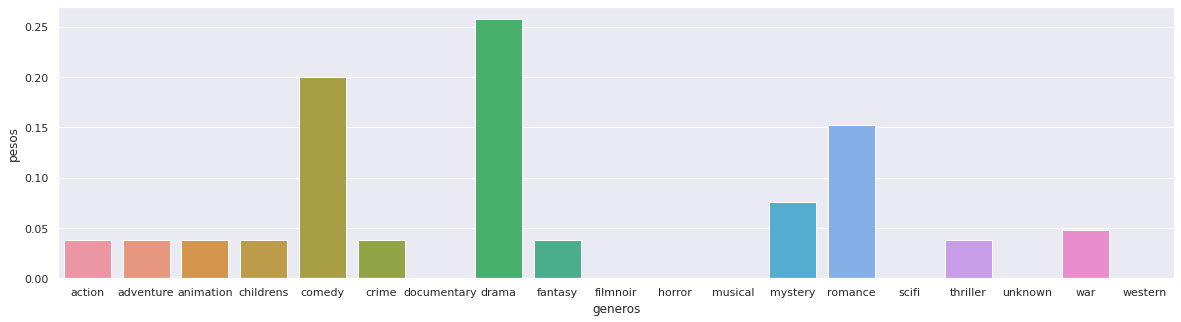

In [ ]:
all_genres = [s.split("|") for s in movie_ratings[movie_ratings.genres.notnull()].genres]
unique_genres = sorted(set([item for l in all_genres for item in l ]))

movie_genres = movie_ratings.copy(deep=True)
movie_genres['genres'] = movie_genres.genres.str.split('|')
for g in unique_genres:
    movie_genres[g] = np.zeros(len(movie_genres))

for index, row in movie_genres.iterrows():
    for genre in row['genres']:
        movie_genres.at[index, genre] = 1

movie_genres.drop(['title','genres','year','vote_count','vote_average','imdb_score'], axis=1, inplace=True)

def create_user_profile(user=None, user_ratings=None):
    if ((user is None) & (user_ratings is None)) | ((user is not None) & (user_ratings is not None)):
        raise Exception('Necessário informar um usuário ou classificações')
    user_ratings = ratings[ ratings['user'] == user ][['item', 'rating']]
    # Valida se todas as classificações são de filmes válidos
    user_ratings = user_ratings[ user_ratings.index.isin(movie_genres.index) ]
    # Calcular o peso de cada gênero para o usuário ou user_ratings
    userdf = movie_genres[ movie_genres.index.isin(user_ratings.index) ].copy()
    up = userdf.T.dot(user_ratings.rating) /  sum(userdf.T.dot(user_ratings.rating))
    return up


import seaborn as sns

def plot_user_profile(user_profile):
    genres = pd.DataFrame(zip(list(user_profile), sorted(user_profile.keys())), columns=['pesos', 'generos'])
    sns.set(rc={'figure.figsize':(20,5)})
    ax = sns.barplot(x="generos", y="pesos", data=genres)

plot_user_profile(create_user_profile(user=1))

### Preparar os arquivos para o ***Surprise***

In [ ]:
ratings.pivot_table(values='rating', index='user', columns='item') 

item,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ratings.head(10)

,user,item,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)

trainset = data.build_full_trainset()
testset = trainset.build_testset()

ausentes = trainset.build_anti_testset()

In [ ]:
print(len(ausentes), len(testset))
ausentes[:10]

1483310 99987


[(196, 302, 3.5299288907557984),
 (196, 377, 3.5299288907557984),
 (196, 51, 3.5299288907557984),
 (196, 346, 3.5299288907557984),
 (196, 474, 3.5299288907557984),
 (196, 265, 3.5299288907557984),
 (196, 465, 3.5299288907557984),
 (196, 451, 3.5299288907557984),
 (196, 86, 3.5299288907557984),
 (196, 1014, 3.5299288907557984)]

### Recomendações usando ***User-User***

In [ ]:
algo = KNNWithMeans(sim_options={'name':'pearson_baseline', 'user_based':True})
algo.fit(trainset)
predictions = algo.test(testset)

pd.DataFrame(predictions).head()


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,196,242,3.0,3.394340,"{'actual_k': 40, 'was_impossible': False}"
1,196,393,4.0,3.775343,"{'actual_k': 40, 'was_impossible': False}"
2,196,381,4.0,3.793376,"{'actual_k': 40, 'was_impossible': False}"
3,196,251,3.0,3.383245,"{'actual_k': 26, 'was_impossible': False}"
4,196,655,5.0,4.520929,"{'actual_k': 40, 'was_impossible': False}"


In [ ]:
print(accuracy.rmse(predictions))

RMSE: 0.4887
0.4886872470218949


Ajustando os hiperparâmetros

In [ ]:
param_grid = {'k': [10, 40], 'verbose': [0],
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [True]}
              }

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3, joblib_verbose=1)
gs.fit(data)

best_uu = gs.best_estimator['rmse']
print(best_uu, best_uu.k, best_uu.sim_options)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


<surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f8289933c50> 40 {'name': 'pearson_baseline', 'user_based': True}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.2min finished


In [ ]:
best_uu.fit(trainset)
predictions = best_uu.test(testset)
print(accuracy.rmse(predictions))

pd.DataFrame(predictions).head()

RMSE: 0.4887
0.4886872470218949


,uid,iid,r_ui,est,details
0,196,242,3.0,3.394340,"{'actual_k': 40, 'was_impossible': False}"
1,196,393,4.0,3.775343,"{'actual_k': 40, 'was_impossible': False}"
2,196,381,4.0,3.793376,"{'actual_k': 40, 'was_impossible': False}"
3,196,251,3.0,3.383245,"{'actual_k': 26, 'was_impossible': False}"
4,196,655,5.0,4.520929,"{'actual_k': 40, 'was_impossible': False}"


#### O problema do ***Cold Start***

Enquanto ainda não se tem avaliações para um usuário, a recomendação colaborativa  não funciona.

***Como obter recomendações para um usuário que ainda não avaliou nenhum filme???***

A avaliação estimada dos filmes será considerada a avaliação média de todos os filmes (não personalizada).

In [ ]:
teste = []
for m in movie_ratings.index:
    teste.append( (-1,m,0) )

predictions = best_uu.test(teste)
pd.DataFrame(predictions, columns=['user', 'movie_id', 'rating', 'pred_rating', 'details']).drop(['details'], axis=1)

,user,movie_id,rating,pred_rating
0,-1,1,0,3.529929
1,-1,2,0,3.529929
2,-1,3,0,3.529929
3,-1,4,0,3.529929
4,-1,5,0,3.529929
...,...,...,...,...
1674,-1,1678,0,3.529929
1675,-1,1679,0,3.529929
1676,-1,1680,0,3.529929
1677,-1,1681,0,3.529929


#### Recomendações

In [ ]:
def get_recommendations(best, ausentes, user, topN=10):
    teste = list(filter(lambda x: x[0]==user, ausentes))
    predictions = best.test(teste)
    df_preds = pd.DataFrame(predictions, columns=['user', 'movie_id', 'rating', 'pred_rating', 'details']).drop(['details'], axis=1)
    colunas = ['movie_id', 'title', 'genres', 'pred_rating', 'imdb_score']
    return df_preds.join(movie_ratings, on='movie_id')[colunas].sort_values(by=['pred_rating','imdb_score'], ascending=False).head(topN)


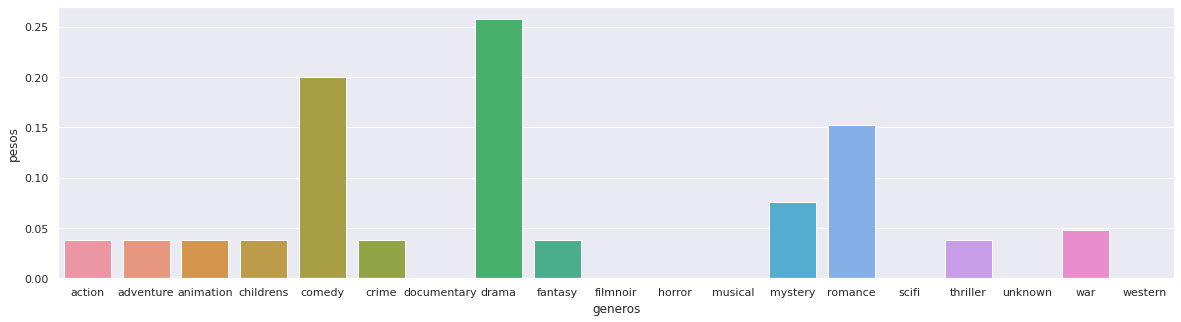

In [ ]:
plot_user_profile(create_user_profile(user=1))

In [ ]:
get_recommendations(best_uu, ausentes, user=1)

,movie_id,title,genres,pred_rating,imdb_score
987,1449,Pather Panchali,drama,5.0,3.217824
948,1167,"Sum of Us, The",comedy,5.0,3.133720
867,1500,Santa with Muscles,comedy,5.0,3.124007
1345,1467,"Saint of Fort Washington, The",drama,5.0,3.124007
424,868,Hearts and Minds,drama,5.0,3.119630
1208,1558,Aparajito,drama,5.0,3.116880
1297,1642,Some Mother's Son,drama,5.0,3.111812
1240,851,Two or Three Things I Know About Her,drama,5.0,3.109149
1301,1628,Lamerica,drama,5.0,3.109149
870,1495,Flirt,drama,5.0,3.107865


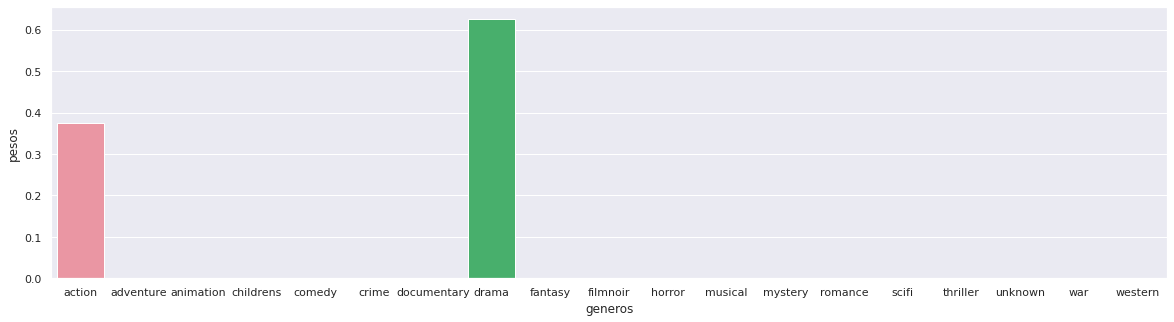

In [ ]:
plot_user_profile(create_user_profile(user=4))

In [ ]:
get_recommendations(best_uu, ausentes, user=4)

,movie_id,title,genres,pred_rating,imdb_score
193,318,Schindler's List,drama|war,5.0,4.172404
231,64,"Shawshank Redemption, The",drama,5.0,4.143715
167,483,Casablanca,drama|romance|war,5.0,4.115073
182,127,"Godfather, The",action|crime|drama,5.0,4.087563
286,12,"Usual Suspects, The",crime|thriller,5.0,4.084059
31,98,"Silence of the Lambs, The",drama|thriller,5.0,4.083337
97,174,Raiders of the Lost Ark,action|adventure,5.0,4.064337
702,313,Titanic,action|drama|romance,5.0,4.028299
36,603,Rear Window,mystery|thriller,5.0,4.024805
48,100,Fargo,crime|drama|thriller,5.0,4.008790


### Recomendações usando ***Item-Item***

In [ ]:
param_grid = {'k': [10, 40], 'verbose': [0],
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [False]}
              }

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3, joblib_verbose=1)
gs.fit(data)

best_ii = gs.best_estimator['rmse']
print(best_ii, best_ii.k, best_ii.sim_options)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


<surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f82795f3590> 40 {'name': 'pearson_baseline', 'user_based': False}


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.5min finished


In [ ]:
best_ii.fit(trainset)
predictions = best_ii.test(testset)
print(accuracy.rmse(predictions))

pd.DataFrame(predictions).head()

RMSE: 0.4817
0.4816904014456842


,uid,iid,r_ui,est,details
0,196,242,3.0,3.307317,"{'actual_k': 16, 'was_impossible': False}"
1,196,393,4.0,3.781910,"{'actual_k': 19, 'was_impossible': False}"
2,196,381,4.0,3.787348,"{'actual_k': 21, 'was_impossible': False}"
3,196,251,3.0,3.375820,"{'actual_k': 23, 'was_impossible': False}"
4,196,655,5.0,4.498170,"{'actual_k': 24, 'was_impossible': False}"


,movie_id,title,genres,pred_rating,imdb_score
777,1189,Prefontaine,drama,5.0,3.146609
867,1500,Santa with Muscles,comedy,5.0,3.124007
1345,1467,"Saint of Fort Washington, The",drama,5.0,3.124007
1297,1642,Some Mother's Son,drama,5.0,3.111812
886,814,"Great Day in Harlem, A",documentary,5.0,3.100846
1027,1536,Aiqing wansui,drama,5.0,3.100846
1288,1599,Someone Else's America,drama,5.0,3.100846
1305,1653,Entertaining Angels: The Dorothy Day Story,drama,5.0,3.100846
1372,1122,They Made Me a Criminal,crime|drama,5.0,3.100846
1373,1201,Marlene Dietrich: Shadow and Light (1996),documentary,5.0,3.100846


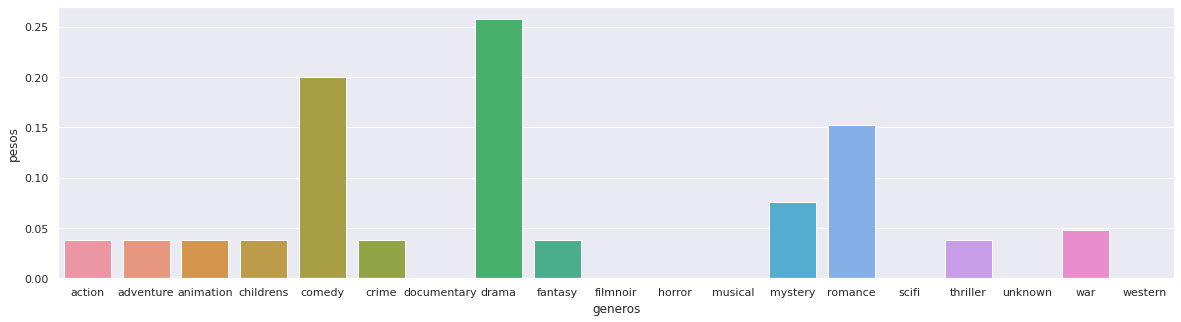

In [ ]:
plot_user_profile(create_user_profile(user=1))
get_recommendations(best_ii, ausentes, user=1)

,movie_id,title,genres,pred_rating,imdb_score
231,64,"Shawshank Redemption, The",drama,5.0,4.143715
167,483,Casablanca,drama|romance|war,5.0,4.115073
36,603,Rear Window,mystery|thriller,5.0,4.024805
48,100,Fargo,crime|drama|thriller,5.0,4.008790
250,134,Citizen Kane,drama,5.0,3.943052
125,272,Good Will Hunting,drama,5.0,3.921470
266,169,"Wrong Trousers, The",animation|comedy,5.0,3.904892
173,408,"Close Shave, A",animation|comedy|thriller,5.0,3.901920
120,479,Vertigo,mystery|thriller,5.0,3.888682
57,515,"Boot, Das",action|drama|war,5.0,3.883162


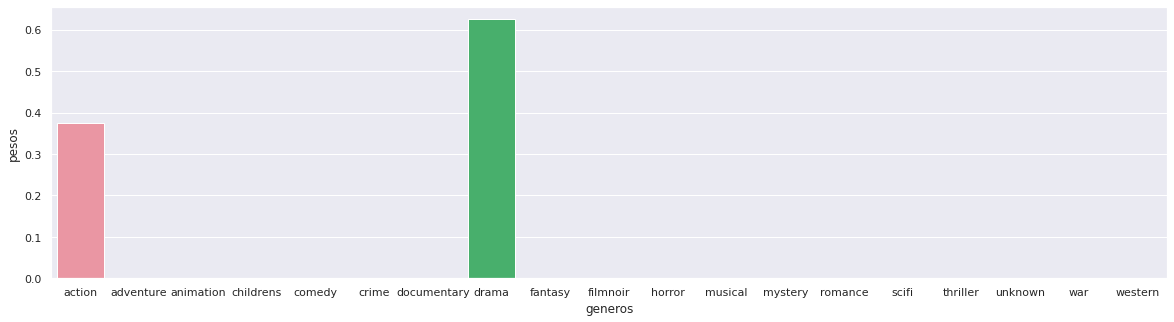

In [ ]:
plot_user_profile(create_user_profile(user=4))
get_recommendations(best_ii, ausentes, user=4)

### Recomendações com ***SVD***

In [ ]:
param_grid = {'n_factors': [5, 10, 15, 20, 25, 30, 40, 50, 100], 'n_epochs': [5, 10, 15, 20, 25, 50], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15], 'verbose': [0]}

param_grid = {'n_factors': [5, 10, 25], 'n_epochs': [15], 'lr_all': [0.003],
              'reg_all': [0.001], 'verbose': [0]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=1)
gs.fit(data)

best_svd = gs.best_estimator['rmse']
print(best_svd, gs.best_params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f827763bcd0> {'rmse': {'n_factors': 5, 'n_epochs': 15, 'lr_all': 0.003, 'reg_all': 0.001, 'verbose': 0}}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   14.0s finished


In [ ]:
best_svd.fit(trainset)
predictions = best_svd.test(testset)
print(accuracy.rmse(predictions))

pd.DataFrame(predictions).head()

RMSE: 0.9177
0.917681828471498


,uid,iid,r_ui,est,details
0,196,242,3.0,4.070085,{'was_impossible': False}
1,196,393,4.0,3.424653,{'was_impossible': False}
2,196,381,4.0,3.607381,{'was_impossible': False}
3,196,251,3.0,4.199470,{'was_impossible': False}
4,196,655,5.0,3.906235,{'was_impossible': False}


,movie_id,title,genres,pred_rating,imdb_score
106,408,"Close Shave, A",animation|comedy|thriller,4.601018,3.901920
116,318,Schindler's List,drama|war,4.524883,4.172404
103,483,Casablanca,drama|romance|war,4.499887,4.115073
18,603,Rear Window,mystery|thriller,4.389738,4.024805
139,357,One Flew Over the Cuckoo's Nest,drama,4.375258,4.009211
3,474,Dr. Strangelove or: How I Learned to Stop Worr...,scifi|war,4.351382,3.909374
41,480,North by Northwest,comedy|thriller,4.347342,3.911848
329,285,Secrets & Lies,drama,4.341545,3.872597
446,657,"Manchurian Candidate, The",filmnoir|thriller,4.341249,3.811225
351,513,"Third Man, The",mystery|thriller,4.317223,3.672162


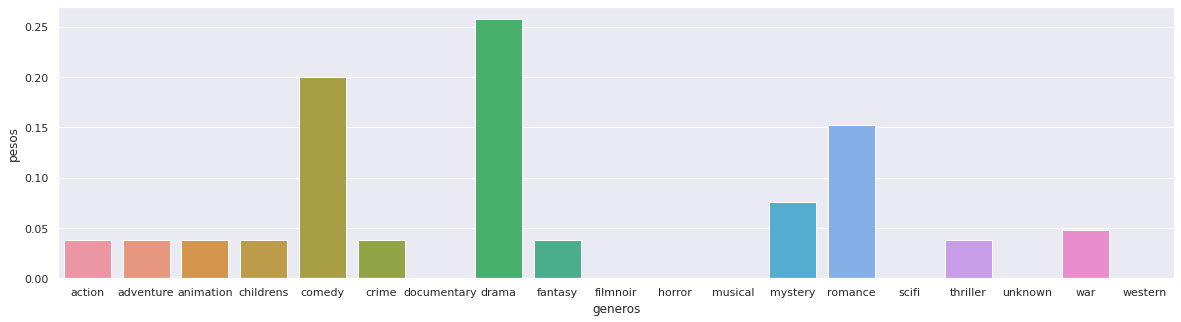

In [ ]:
plot_user_profile(create_user_profile(user=1))
get_recommendations(best_svd, ausentes, user=1)

,movie_id,title,genres,pred_rating,imdb_score
193,318,Schindler's List,drama|war,5.000000,4.172404
231,64,"Shawshank Redemption, The",drama,5.000000,4.143715
167,483,Casablanca,drama|romance|war,5.000000,4.115073
286,12,"Usual Suspects, The",crime|thriller,5.000000,4.084059
36,603,Rear Window,mystery|thriller,5.000000,4.024805
266,169,"Wrong Trousers, The",animation|comedy,5.000000,3.904892
173,408,"Close Shave, A",animation|comedy|thriller,5.000000,3.901920
596,114,Wallace & Gromit: The Best of Aardman Animation,animation,4.995253,3.701827
178,178,12 Angry Men,drama,4.994202,3.849603
643,657,"Manchurian Candidate, The",filmnoir|thriller,4.976671,3.811225


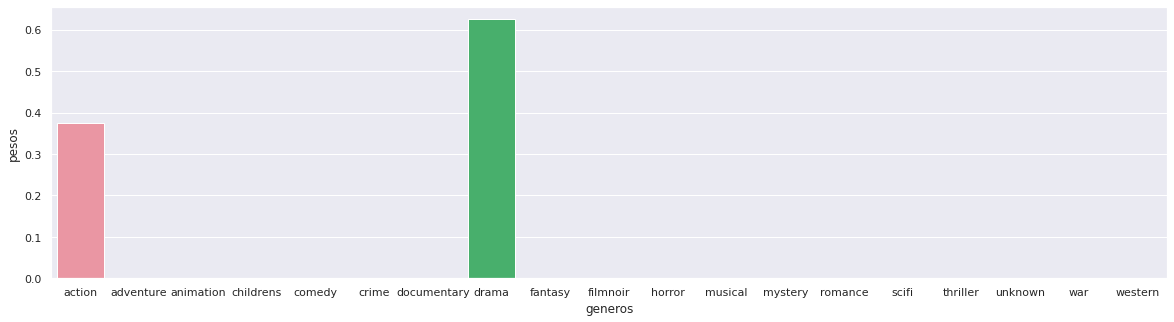

In [ ]:
plot_user_profile(create_user_profile(user=4))
get_recommendations(best_svd, ausentes, user=4)

### Recomendações combinando as 3 abordagens

,movie_id,title,genres,pred_rating_avg,imdb_score
106,408,"Close Shave, A",animation|comedy|thriller,4.747034,3.901920
103,483,Casablanca,drama|romance|war,4.633384,4.115073
987,1449,Pather Panchali,drama,4.585775,3.217824
867,1500,Santa with Muscles,comedy,4.537630,3.124007
116,318,Schindler's List,drama|war,4.534748,4.172404
1345,1467,"Saint of Fort Washington, The",drama,4.531188,3.124007
329,285,Secrets & Lies,drama,4.525786,3.872597
1297,1642,Some Mother's Son,drama,4.521567,3.111812
18,603,Rear Window,mystery|thriller,4.501319,4.024805
1288,1599,Someone Else's America,drama,4.497572,3.100846


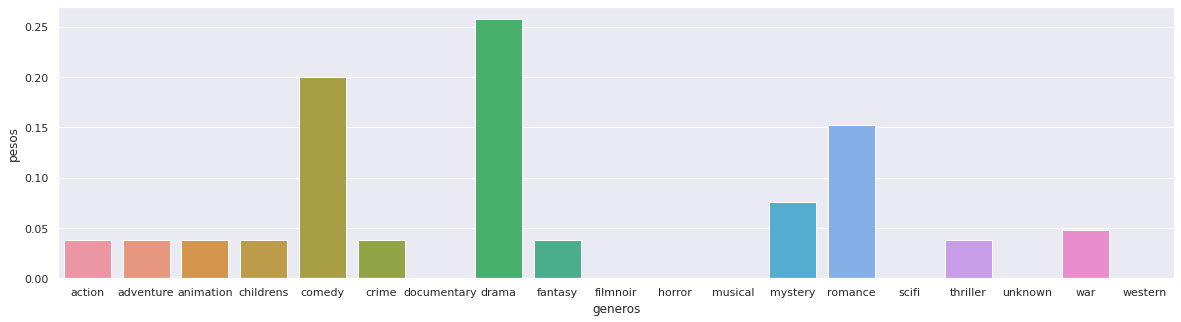

In [ ]:
def get_mix_recommendations(best_list, ausentes, user, topN=10):
    teste = list(filter(lambda x: x[0]==user, ausentes))
    predictions = []
    for i,m in enumerate(best_list):
        pred = m.test(teste)
        predictions.append(pred)
        if i == 0:
            df_preds = pd.DataFrame(pred, columns=['user', 'movie_id', 'rating', 'pred_rating_0', 'details']).drop('details', axis=1)
            df_preds['aux'] = df_preds['pred_rating_0']
        else:
            aux = pd.DataFrame(pred, columns=['user', 'movie_id', 'rating', 'pred_rating', 'details'])
            df_preds['pred_rating_' + str(i)] = aux['pred_rating']
            df_preds['aux'] += df_preds['pred_rating_' + str(i)]

    df_preds['pred_rating_avg'] = (df_preds['aux'] / len(best_list))
    colunas = ['movie_id', 'title', 'genres', 'pred_rating_avg', 'imdb_score']
    return df_preds.join(movie_ratings, on='movie_id')[colunas].sort_values(by=['pred_rating_avg','imdb_score'], ascending=False).head(topN)

plot_user_profile(create_user_profile(user=1))
get_mix_recommendations([best_uu, best_ii, best_svd], ausentes, user=1)